In [1]:
import numpy as np
import matplotlib.pyplot as plt

$$
L(\theta) = \sum i t_i + \prod t_i^{-1}
$$

$$
\frac{\partial L}{\partial t_i} = i - t_i ^{-1} \prod t_j^{-1}
$$

$$
\frac{\partial^2 L}{\partial t_i^2} = 2 t_i ^{-2} \prod t_j^{-1}
$$

In [2]:
def loss_7p14(theta):
    return theta @ np.arange(1, len(theta) + 1) + np.prod(1/theta)

def grad_7p14(theta):
    # prod tj^-1 either way
    prod_part = np.prod(1/theta)
    return np.arange(1, len(theta) + 1) - prod_part/theta

def hess_7p14(theta):
    prod_part = np.prod(1/theta)
    return 2 * prod_part / (theta **2)

Find $\theta^*$ via Newton's method using calculated first and second order partial derivatives of the loss function

In [58]:
P = 10
theta = np.ones(P)
last_loss = loss_7p14(theta)
a0 = 0.1
a = a0
for i in range(1000):
    grad = grad_7p14(theta)
    hess = hess_7p14(theta)
    ht = grad / hess
    theta_c = theta - .1 * ht
    loss_diff = last_loss - loss_7p14(theta_c)
    if a < 1e-12:
        print("No more improvement, stopping")
        break
    if loss_diff <= 0:
        a /= 2
        continue
    a = a0
    theta = theta_c
    last_loss = loss_7p14(theta)
    if i % 200 == 0:
        print(f"Iter {i}: {loss_7p14(theta)}")
        print("   Theta:", " ".join([np.format_float_positional(ti, 3) for ti in theta]))


print(f"Iter {i}: {loss_7p14(theta)}")
print("   Theta:", " ".join([np.format_float_positional(ti, 3) for ti in theta]))
theta_optimal = np.array(theta)

Iter 0: 53.77349308567059
   Theta: 1. 0.95 0.9 0.85 0.8 0.75 0.7 0.65 0.6 0.55
Iter 200: 43.4244952732134
   Theta: 3.947 1.974 1.316 0.987 0.79 0.658 0.564 0.493 0.439 0.395
No more improvement, stopping
Iter 360: 43.42449524833548
   Theta: 3.948 1.974 1.316 0.987 0.79 0.658 0.564 0.493 0.439 0.395


Now use SPSA with noise injected into loss function

$a = 0.01$, $A = 1000$, $c = 0.015$, $\alpha = 0.602$, $\gamma = 0.101$

In [61]:
# noise is theta, 1 * I_11 V so dot product
def noise_7p14(theta):
    return np.append(theta, 1) @ np.random.normal(0, 0.001, size=11)

def norm_loss_genfnc(loss_fnc, theta_0, theta_optimal):
    # from 7.3 example
    return lambda theta: (loss_fnc(theta) - loss_fnc(theta_optimal)) / (loss_fnc(theta_0) - loss_fnc(theta_optimal))

def bernouli_sample(p):
    while True:
        proba = np.random.rand(p)
        values = (proba < 0.5).astype(int) * 2 - 1
        yield values

def a_gain(a, A, alpha):
    """Coroutine, send k and get ak"""
    k = 0
    while True:
        kc = yield a / (k + 1 + A)**alpha
        k += 1
        if kc is not None:
            print(f"Setting k = {kc}")
            k = kc
            yield # pause

def c_gain(c, gamma):
    """Coroutine, send k and get ck"""
    k = 0
    while True:
        kc = yield c / (k + 1)**gamma
        k += 1
        if kc is not None:
            print(f"Setting k = {kc}")
            k = kc
            yield # pause

def approx_gradient(loss, perturb, theta, c):
    # SPSA
    diff = loss(theta + c * perturb) - loss(theta - c * perturb)
    return (diff / (2 * c)) / perturb

def grad_step(theta, a, grad):
    return theta - a * grad

In [54]:
ak_gen = a_gain(0.01, 1000, 0.602)
ck_gen = c_gain(0.015, 0.101)

for i, ak, ck in zip(range(3), ak_gen, ck_gen):
    print(i, ak, ck)

0 0.0001562207380859837 0.015
1 0.00015612686226702544 0.013985797296552487
2 0.00015603313641707892 0.013424620340351448


I'm curious how well it does (after I did fixes to algo) and given a naive starting point estimate (theta = ones)

In [69]:
theta = np.ones(P)
losses = []
ak_gen.send(0)
ck_gen.send(0)
for perturb, ak, ck, i in zip(bernouli_sample(P), ak_gen, ck_gen, range(20_000)):
    loss = loss_7p14(theta) + noise_7p14(theta)
    if i % 4_000 == 0:
        print(f"Iter {i}: {loss_7p14(theta)}")
        print("   Theta:", " ".join([np.format_float_positional(ti, 3) for ti in theta]))
        print(f"    ak={ak} ck={ck}")
    grad = approx_gradient(loss_7p14, perturb, theta, ck)
    theta = grad_step(theta, ak, grad)
    losses.append(loss)
print(f"Iter {i}: {loss_7p14(theta)}")
print("   Theta:", " ".join([np.format_float_positional(ti, 3) for ti in theta]))

Setting k = 0
Setting k = 0
Iter 0: 56.0
   Theta: 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    ak=0.0001562207380859837 ck=0.015
Iter 4000: 44.85935672705365
   Theta: 1.770 1.512 1.285 1.078 0.915 0.773 0.656 0.572 0.506 0.451
    ak=5.931544235328241e-05 ck=0.006490411543244501
Iter 8000: 44.37415366579187
   Theta: 2.023 1.652 1.342 1.09 0.891 0.737 0.624 0.544 0.485 0.437
    ak=4.1640598352471345e-05 ck=0.006051648401591164
Iter 12000: 44.1614199746292
   Theta: 2.176 1.73 1.366 1.08 0.872 0.721 0.613 0.536 0.476 0.429
    ak=3.337228866524169e-05 ck=0.005808851819934929
Iter 16000: 44.037117843000516
   Theta: 2.286 1.78 1.376 1.073 0.859 0.710 0.608 0.531 0.471 0.424
    ak=2.839581713053996e-05 ck=0.005642510805208821
Iter 19999: 43.952827584146185
   Theta: 2.372 1.816 1.382 1.065 0.849 0.706 0.603 0.528 0.468 0.420


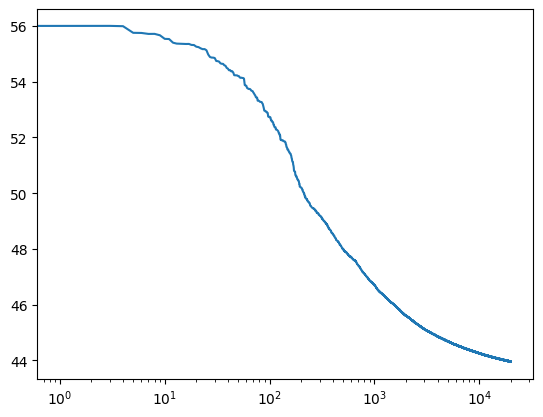

In [70]:
plt.plot(losses)
plt.xscale('log')

Now do part (b) actually and have $\hat{\theta}_0 = 1.1\theta^*$

In [71]:
theta = theta_optimal * 1.1
norm_loss = norm_loss_genfnc(loss_7p14, theta_optimal * 1.1, theta_optimal)
losses = []
ak_gen.send(0)
ck_gen.send(0)
for perturb, ak, ck, i in zip(bernouli_sample(P), ak_gen, ck_gen, range(20_000)):
    loss = loss_7p14(theta) + noise_7p14(theta)
    if i % 2_000 == 0:
        print(f"Iter {i}: {loss_7p14(theta)}")
        print("   Theta:", " ".join([np.format_float_positional(ti, 3) for ti in theta]))
        print(f"    ak={ak} ck={ck}")
    grad = approx_gradient(loss_7p14, perturb, theta, ck)
    theta = grad_step(theta, ak, grad)
    losses.append(norm_loss(theta))
print(f"Iter {i}: {loss_7p14(theta)}")
print("   Theta:", " ".join([np.format_float_positional(ti, 3) for ti in theta]))

Setting k = 0
Setting k = 0
Iter 0: 44.94649731559552
   Theta: 4.342 2.171 1.447 1.086 0.868 0.724 0.620 0.543 0.482 0.434
    ak=0.0001562207380859837 ck=0.015
Iter 2000: 43.46680767139707
   Theta: 4.328 2.113 1.371 0.990 0.779 0.641 0.545 0.477 0.424 0.382
    ak=8.066513607414323e-05 ck=0.00696089853109683
Iter 4000: 43.4555150660216
   Theta: 4.313 2.09 1.347 0.979 0.774 0.642 0.550 0.482 0.429 0.386
    ak=5.931544235328241e-05 ck=0.006490411543244501
Iter 6000: 43.45060062833808
   Theta: 4.303 2.075 1.335 0.975 0.774 0.644 0.553 0.484 0.430 0.387
    ak=4.844105947939939e-05 ck=0.00623003767169601
Iter 8000: 43.44771670194914
   Theta: 4.294 2.064 1.328 0.973 0.775 0.646 0.554 0.485 0.431 0.388
    ak=4.1640598352471345e-05 ck=0.006051648401591164
Iter 10000: 43.44563072407608
   Theta: 4.287 2.055 1.323 0.973 0.776 0.647 0.555 0.486 0.432 0.389
    ak=3.6902674017471305e-05 ck=0.005916799774137484
Iter 12000: 43.44406223749469
   Theta: 4.281 2.048 1.319 0.973 0.776 0.648 0.5

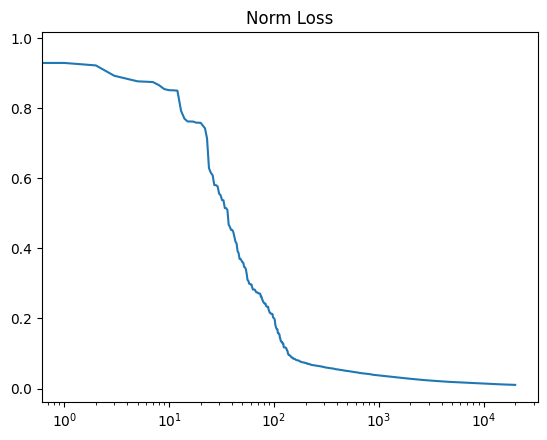

In [72]:
plt.plot(losses)
plt.title("Norm Loss")
plt.xscale('log')

In [73]:
losses[-1]

0.010360339357833868